# Lab 7: Inference and Global Climate Change 

By the end of this lab, you should know how to:

1. Test whether observed data appears to be a random sample from a distribution.
2. Analyze a natural experiment.
3. Implement and interpret a sign test.
4. Create a function to run a general hypothesis test.
5. Analyze visualizations and draw conclusions from them.

In [1]:
name = "Lexi Yoza"

In [2]:
## import statements
# These lines load the tests. 
from gofer.ok import check

import numpy as np
from datascience import *
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
user = os.getenv('JUPYTERHUB_USER')

## Overview 

Climate change is usually referring to the general trend of warming temperatures globally.  Along with these increasing temperatures, unusual shifts in trends in weather activity such as hurricanes, storms, winds, etc are also usually classified under climate change.  While the climate can shift due to natural occurrences, scientists have found that human interventions have contributed to the trend of warming.  One explanation for the warming could be increased solar solar activity, however scientists have found that solar activity has not generally increased during the period when temperature has increased.  

<img src='solar_temp.jpg' width="500" height="340">

Links: [NASA](https://climate.nasa.gov/causes/) [Canada](https://www.canada.ca/en/environment-climate-change/services/climate-change/causes.html)

### Data 

While there's several different metrics we could analyze to make some inferences about overall trends in global climate change, for simplicity's sake we will be focusing on land temperature across different countries.  The original table came from this [database](https://github.com/OpenFloodAI/Climate-Change-Datasets), however it's been reformatted to make the downstream analyses easier.  There are 15 columns: Year, Country, Average Temperature of that country in that year 'avg', and then a column for each month of that year with temperatures.  

In [3]:
temps = Table.read_table('temp_per_country.csv')
temps

year,country,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1753,Åland,5.11833,-2.412,-3.273,0.71,2.778,6.226,11.102,15.159,15.786,12.106,8.756,2.248,-7.766
1753,Albania,12.557,1.4,2.655,8.505,11.541,16.642,22.098,23.532,21.77,18.7,13.661,7.593,2.587
1753,Andorra,11.2345,0.938,4.083,8.352,9.165,13.783,19.796,21.148,18.796,16.546,11.706,5.991,4.51
1753,Austria,6.13892,-6.398,-3.537,2.681,6.498,11.331,16.209,16.881,14.751,12.34,7.072,-0.011,-4.15
1753,Belarus,5.65175,-7.122,-6.956,0.706,6.768,13.06,16.615,18.032,16.501,12.448,6.84,0.024,-9.095
1753,Belgium,9.45708,-1.215,2.443,6.838,8.826,13.042,17.602,18.072,16.203,14.761,10.332,4.143,2.438
1753,Bosnia And Herzegovina,10.3656,-1.973,0.043,6.558,10.293,15.253,20.463,21.589,19.567,16.607,11.343,4.776,-0.132
1753,Bulgaria,10.3995,-1.841,-0.883,5.889,10.043,15.723,20.69,22.084,20.446,17.03,11.668,5.201,-1.256
1753,Croatia,11.2875,-1.311,1.012,7.5,11.318,16.33,21.666,22.721,20.52,17.527,12.113,5.342,0.712
1753,Czech Republic,7.49492,-4.72,-2.339,3.956,8.117,12.84,17.184,18.175,16.392,13.701,8.464,1.475,-3.306


### Data Exploration
Let's explore this data a bit.  We will start by getting a list of all of the countries. 

In [4]:
np.unique(temps['country'])

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Anguilla', 'Antigua And Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Asia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Baker Island', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burma', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros', 'Congo',
       'Congo (Democratic Republic Of The)', 'Costa Rica', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', "Côte D'Ivoire",
       'Denmark', 'Denmark (Europe)', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',

Noticd that entries are continents, not countries, and there are a few duplicates such Netherlands and Netherlands (Europe). Cleaning the data is virtually always the first step.

Let's remove them.

In [5]:
# Use the where() method in a loop to remove unwanted rows
non_countries_and_dups = [
    "Africa",
    "Denmark (Europe)",
    "Europe",
    "France (Europe)",
    "French Southern And Antarctic Lands",
    "Kingman Reef",
    "Netherlands (Europe)",
    "North America",
    "Oceania",
]
for country in non_countries_and_dups:
    temps = temps.where('country', are.not_equal_to(country))

## Part 1: Basic Hypothesis Testing

### How has the average temperature changed between 1850 and 2000?
Has the Earth warmed? If we look at the temperature changes for all of the countries, what will we see?

Let's investigate...

In [6]:
T_1850 = temps.where('year', 1850).select('year', 'country', 'avg')
T_2000 = temps.where('year', 2000).select('year', 'country', 'avg')

temp_change = T_1850.join('country', T_2000, 'country').relabel('avg', 'T1').relabel('avg_2', 'T2')
temp_change = temp_change.with_columns('T_diff', temp_change.column('T2') - temp_change.column('T1'))

temp_change.show(3)

country,year,T1,year_2,T2,T_diff
Afghanistan,1850,13.3261,2000,15.4978,2.17175
Albania,1850,11.7347,2000,13.7466,2.01192
Algeria,1850,22.5873,2000,24.0323,1.44492


### <font color=blue> **Question 1.** </font>
Calculate the average temperature change across all countries in the data set.

In [7]:
#temp_change.column('T_diff')
mean_diff = np.average(temp_change.column('T_diff'))
mean_diff

1.4841057291666666

In [8]:
check('tests/q1.py')

### <font color=blue> **Question 2.** </font>
Make a histogram of the temperature changes. The, in markdown cell below  the histogram, describe the distribution. Do you think these changes could be random? Why or why not?

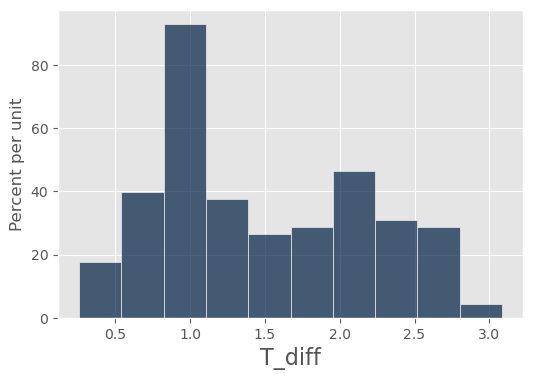

In [9]:
temp_change.hist("T_diff")

There is the most countries with a temperature difference of about 1.0. However, overall it is distributed pretty well. I dont think these changes are random, I think they are likely correlated to the pollution levels and green house gas release of certain countries.

### <font color=blue> **Question 3.** </font>
Let's test whether the change in mean temperature between 1850 and 2000 is statistically significant. In the cell below, formulate an hypothesis and a null hypothesis.

#### Hypothesis:
There will be a statistically significant change in temperature between 1850 and 2000.

#### Null Hypothesis:
There will not be a statistically significant change in temperature between 1850 and 2000.

## Hypothesis testing
**We are going to test null hythosis two ways:<br>**
First, we will use a standard paired t-test taught in traditional statistics classes.<br>
Second, we will use a simulation approach taught in this class, an approach we will use from now on.

## What is a "paired t-test?"
The <i>t</i>-test was developed by a chemist, William Gosset, working for the Guiness brewery in 1908. He didn't want competitors to know the statistical methods he developed were being using at the brewery for quality control, so he published his papers under the pen name "Student," hence the test became knows as the Student t-test.

What Gosset shows was that:
* **IF** two samples are independent
* and **IF** the samples are random
* and **IF** both samples come from populations with a normal distribution
* and **IF** both populations have approximately the same standard deviation
* **THEN** we can calculate the following t-statistic

  $$ t = \frac{\bar{x_1} - \bar{x_2}}{SE} $$
  
with is the difference between the means of the two samples divided by average standard error of the mean, or standard error, for short.

$$ SE^2 = \frac{(SE)_1^2 + (SE)_2^2}{2} $$

What is the "standard error?" It is sample standard deviation divided by the square root of the number of observations:

$$ SE = \frac{s}{\sqrt{n}} $$

The standard error tells you how much the sample mean would vary if you were to repeat a study using new samples from the same population. Notice that the more data you have in your sample, the smaller the standard error, so the less uncertainty you have in your sample mean.

You can think of this this way: the signal in your data is the difference between the two means -- before and after treatment -- or in our case, between two different time periods. The noise is the variation of the data around the the means (standard deviation). If the signal is large compared with the noise, we can reject the null hypothesis, but if difference between the means is small compared with the scatter of the data around the means, the distributions will blur together and we cannot reject the null hypothesis that the observations could be the result of random variation.

A **paired t-test** is a variation of the t-test where we are looking at paired data -- measurements are made before after some experiment. For example, patients before and after treatment, or in our case, the annual temperature before and after 164 years of industialization. 

In this case, the null hypothesis is that the average difference between past and present temperatures is zero. So the t-value becomes.

$$ t = \frac{\bar{x}_{diff}}{SE} $$

Look at this closely. The paired t-value measures how far the average paired differences are from zero relative to the standard error. 

In [60]:
s1 = np.std(temp_change.column('T1'))
s2 = np.std(temp_change.column('T2'))
s = np.sqrt((s1**2 + s2**2) / 2)
dof = 2 * temp_change.num_rows - 2

mean_diff = np.mean(temp_change.column('T_diff'))
s = np.std(temp_change.column('T_diff'))
n = temp_change.num_rows
std_error = s / np.sqrt(n)

print(f'The mean temperature change is: {mean_diff:.2f}')
print(f'The standard deviation of the temperature differences is: {s:.3f}')
print(f'The standard error is: {std_error:.4f}')
print(f'The degrees of freedom is: {dof}')

The mean temperature change is: 1.48
The standard deviation of the temperature differences is: 0.689
The standard error is: 0.0545
The degrees of freedom is: 318


### <font color=blue> **Question 4.** </font>
Calculate the t-value.

In [11]:
t = mean_diff/std_error
print("The t value is:", t)

The t value is: 27.2363666509


In [12]:
check('tests/q4.py')

### **Find the p-value** 
This is where the magic occurs in traditional statistics classes. 
    
**Magical Degrees of freedom:** You need to know the "degrees of freedom," which is number of sample points in your samples minus the number of statistics you have already used calculated using the data. (Note: for large data sets the number of degrees of freedom is nearly equal to the number of observations). You estimated the mean and the standard deviation, so above we subtracted 2 from the number of observations.

**Magical p-values:**
Now that you have a t-statistic and the degrees of freedom, can use a table or [an online calculator](https://www.statology.org/t-score-p-value-calculator/) to find the p-value and enter it below, or you can look up values in a table such as [Students-t-table-one-tailed-two-tailed.](https://postimg.cc/RNrSSGdv). Values of the t-statistic that are greater then or equal to the value in the table have a maximal value of p from the table. For example, with 10 degrees of freedom and a t-statistic of 2.30 we exceed the critical value of 2.23 but are less then the value of 3.17 so the p-value is less then 0.05 but greater then 0.01. When the degrees of freedom reaches the bottom of the table then the t-distribution is nearly equal to the normal distribution and we use the values in the row with degrees of freedom labelled $\infty$.

<br>**<center>Critical Values of <i>t**
    <center>See: [NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3672.htm)

|$\nu$<br>degrees of freedom|95%<br>p = 0.05|99%<br>p = 0.01|
|:-:|:--|:--|
|2|4.303|9.92|
|3|3.18|5.84|
|4|2.78|4.60|
|5|2.57|4.03|
|6|2.45|3.71|
|7|2.36|3.50|
|8|2.31|3.36|
|9|2.26|3.25|
|10|2.23|3.17|
|15|2.13|2.95|
|20|2.09|2.85|
|30|2.04|2.75|
|$\infty$|1.96|2.58|




### <font color=blue> **Question 5.** </font>
The p-value is the probability that the observed temperature increases are random. Obtain an estimate of this value from the table above or the linked tables above. Based on the p-value do we accept or reject the null hypothesis?  Explain in the cell below the check of the p-value.

In [13]:
p = 0.0005

In [14]:
check('tests/q5.py')

<font color='blue'>**Can we reject the null hypothesis? Why or why not?**

We can reject the null hypothesis because the t value is greater than the t at p=0.01 and with 2 degrees of freedom. 

## Simulation Approach
Now we will use the second approach to finding a p-value. No formulas, no tables of critical values, no magic, just simulation. 

We have paired temperatures, but under the null hypothesis it should make no difference which of the two temperatures for each country we assign to 1850 and which to 2000, because the null hypothesis assumes no global warming. This is analogous to testing a drug. Under the null hypothesis it would not matter which patient we assign to the control group and which to the treatment group because the null hypothesis is that the drug has no effect.

To simulate this, for each country we randomly assign one of the two temperatures to 1850 and the other to 2000. We then calculate the mean temperature difference. We do this over and over, saving the mean temperature difference each time. This way we build up a distribution of mean temperature differences assuming no global warming. Once we have that distribution, we calculate the p-value as the fraction of the simulated mean differences are as large or larger than the observed mean difference. If this happened one in a hundred times, we'd say the p-value was 1%.

To randomly change the order of T1 and T1, we can using np.random.shuffle(), a function the randomly shuffles the order of an array of numbers, though in this case each array will have just two values: the average temperature in 1850 and average temperature in 2000.

In [15]:
def shuffle_diff(T1, T2):
    '''
    This function takes two values and returns randomly either:
    (T1 - T2) or (T2 - T1) with equal probability.
    '''
    paired_temperatures = make_array(T1, T2)
    np.random.shuffle(paired_temperatures)
    return paired_temperatures[0] - paired_temperatures[1]

In [16]:
# Test the function
T1 = 1
T2 = 2
for _ in np.arange(10):
    print(shuffle_diff(T1, T2))

1
-1
-1
-1
1
-1
1
1
1
-1


In [17]:
# Test applying the function to our data table
temp_change_simulate = temp_change.with_columns('T_diff_sim', temp_change.apply(shuffle_diff, 'T1', 'T2'))
temp_change_simulate.show(10)

country,year,T1,year_2,T2,T_diff,T_diff_sim
Afghanistan,1850,13.3261,2000,15.4978,2.17175,-2.17175
Albania,1850,11.7347,2000,13.7466,2.01192,-2.01192
Algeria,1850,22.5873,2000,24.0323,1.44492,1.44492
Andorra,1850,10.6517,2000,12.3119,1.66017,1.66017
Anguilla,1850,26.1063,2000,27.0528,0.946417,0.946417
Antigua And Barbuda,1850,25.9333,2000,26.8921,0.958833,-0.958833
Armenia,1850,7.79317,2000,9.91817,2.125,-2.125
Aruba,1850,27.4382,2000,28.128,0.689833,0.689833
Asia,1850,6.58675,2000,8.25258,1.66583,1.66583
Austria,1850,5.53667,2000,8.08492,2.54825,-2.54825


### <font color=blue> **Question 5.** </font>
Explain why in the table above the sign of T_diff and T_diff_sim is sometimes the same and sometimes reversed.

It is sometimes negative because it will randomly switch T1 and T2 so if the higher value, usually T2, is first then the value will be negative, because a value minus a higher value is negative.

In [21]:
# Simulate doing this over and over.
# Each iteration we shuffle the order of the paired temperatures.
# Store each simulated mean of all the temperature differences in the list: "simulated_diffs"
num_simulations = 10000
simulated_diffs = []
for _ in np.arange(num_simulations):
    temp_change_simulate = temp_change.with_columns('T_diff_sim', temp_change.apply(shuffle_diff, 'T1', 'T2'))
    simulated_diffs.append(np.mean(temp_change_simulate.column('T_diff_sim'))) 

### <font color=blue> **Question 6.** </font>
Make a histogram of simulated_diffs. *Hint*: You can either use matplotlib commands directly, or you can put the simulated differences into a table and use the .hist() method.

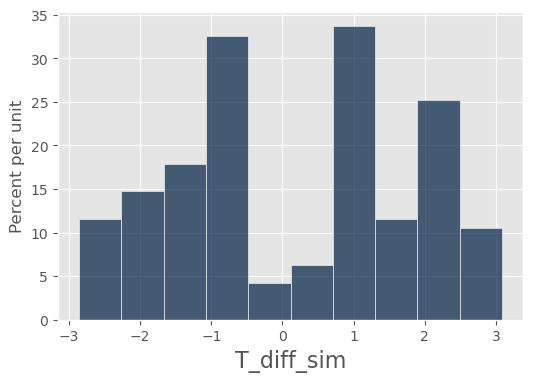

In [19]:
temp_change_simulate.hist('T_diff_sim')

### <font color=blue> **Question 7.** </font>
The p-value is the fraction of temperature diffences simulates under the null hypothesis that greater than or equal to the observed average temperature change between 1850 and 2000.

Calculate the p-value.

In [22]:
s_sim = np.std(temp_change_simulate.column('T_diff_sim'))
n_sim = temp_change_simulate.num_rows
std_error_sim = s_sim / np.sqrt(n_sim)

p_val_simulation = (np.average(temp_change_simulate.column('T_diff_sim')))/(std_error_sim)
print(f"P-value from simulation: {p_val_simulation}")    

P-value from simulation: -1.0508291641522822


In [23]:
check('tests/q7.py')

## NULL Hypothesis rejected!
The histogram shows the distribution of possible temperature changes under the null hypothesis. The blue triangle show the actual mean change in temperature. We see that the average of the actual change in temperatures from 1950 to 2000 lies well beyond the distribution of differences we simulated assuming no global warming. Again, the p-value virually zero, so we reject the null hypothesis. Yes, the planet is warming.

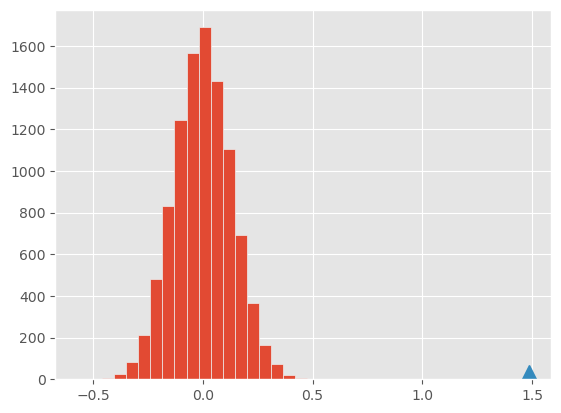

In [24]:
plt.hist(simulated_diffs, bins=20)
plt.plot(mean_diff, 0, '^', markersize=20);

### <font color=blue> **Question 8.** </font>
**<font color=blue> Which approach do you prefer? <font>**
    
**Do you wish this class taught you a bunch of statistical equations, the underlying assumptions and rules for when to use each test, or do you prefer to learn a little Python and test hypotheses by running simulations?** 
    
Learn the equations or learn to code? Which do you prefer and why? We are really curious.<br>
Use the markdown cell below for your answer. 

Learning code is much more efficient. Once you learn the code it allows you to quickly analyze data. The code part is really hard though.

To see another example hypothesis testing using simulation, [read this chapter](https://inferentialthinking.com/chapters/12/3/Deflategate.html?highlight=t+testz)
in your textbook about the football controvery known as "deflategate."

## Part 2: Testing a trend

### <font color=blue> **Question 9.** </font>
The cell below creates a pivot table with years as the rows and each country as a new column. We use the 'avg' column which contains the  average annual temperature. 

In [25]:
pivotTable = temps.select('year', 'country', 'avg').pivot('country', 'year', 'avg', sum)
pivotTable

year,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua And Barbuda,Argentina,Armenia,Aruba,Asia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Baker Island,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,"Bonaire, Saint Eustatius And Saba",Bosnia And Herzegovina,Botswana,Brazil,British Virgin Islands,Bulgaria,Burkina Faso,Burma,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Central African Republic,Chad,Chile,China,Christmas Island,Colombia,Comoros,Congo,Congo (Democratic Republic Of The),Costa Rica,Croatia,Cuba,Curaçao,Cyprus,Czech Republic,Côte D'Ivoire,Denmark,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Ethiopia,Falkland Islands (Islas Malvinas),Faroe Islands,Federated States Of Micronesia,Fiji,Finland,France,French Guiana,French Polynesia,Gabon,Gambia,Gaza Strip,Georgia,Germany,Ghana,Greece,Greenland,Grenada,Guadeloupe,Guam,Guatemala,Guernsey,Guinea,Guinea Bissau,Guyana,Haiti,Heard Island And Mcdonald Islands,Honduras,Hong Kong,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Isle Of Man,Israel,Italy,Jamaica,Japan,Jersey,Jordan,Kazakhstan,Kenya,Kiribati,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Lesotho,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,Macau,Macedonia,Madagascar,Malawi,Malaysia,Mali,Malta,Martinique,Mauritania,Mauritius,Mayotte,Mexico,Moldova,Monaco,Mongolia,Montenegro,Montserrat,Morocco,Mozambique,Namibia,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Niue,North Korea,Northern Mariana Islands,Norway,Oman,Pakistan,Palau,Palestina,Palmyra Atoll,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russia,Rwanda,Saint Barthélemy,Saint Kitts And Nevis,Saint Lucia,Saint Martin,Saint Pierre And Miquelon,Saint Vincent And The Grenadines,Samoa,San Marino,Sao Tome And Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Sint Maarten,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South America,South Georgia And The South Sandwich Isla,South Korea,Spain,Sri Lanka,Sudan,Suriname,Svalbard And Jan Mayen,Swaziland,Sweden,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,Timor Leste,Togo,Tonga,Trinidad And Tobago,Tunisia,Turkey,Turkmenistan,Turks And Caicas Islands,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Kingdom (Europe),United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Virgin Islands,Western Sahara,Yemen,Zambia,Zimbabwe,Åland
1753,0,12.557,0,0,11.2345,0,0,0,0,0,0,0,0,6.13892,0,0,0,0,0,0,5.65175,9.45708,0,0,0,0,0,10.3656,0,0,0,10.3995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.2875,0,0,0,7.49492,0,0,0,0,0,0,0,0,0,0,4.6585,0,0,6.49958,0,0,1.12117,12.7718,0,0,0,0,0,0,8.02917,0,14.7132,0,0,0,0,0,10.926,0,0,0,0,0,0,0,9.61875,1.3155,0,0,0,0,9.36908,9.30625,0,12.7374,0,0,10.926,0,0,0,0,0,0,0,5.13533,0,0,0,0,4.6125,5.70917,9.13775,0,10.3112,0,0,0,0,18.4743,0,0,0,0,0,8.81283,9.06558,0,10.1555,0,0,0,0,0,9.44008,0,0,0,0,0,0,0,0,-0.0538333,0,0,0,0,0,0,0,0,0,0,7.26283,14.6823,0,0,0,8.65533,0,0,0,0,0,0,4.21583,0,0,13.8162,0,0,0,9.91017,0,0,0,0,7.39567,9.61117,0,0,0,0,0,0,13.6281,0,0,0,0,0,2.19492,6.995,0,0,0,0,0,0,0,0,0,19.9612,0,0,0,0,7.52508,0,8.42608,8.59308,0,0,0,0,0,0,0,0,0,0,5.11833
1754,0,12.5482,0,0,11.1162,0,0,0,0,0,0,0,0,5.90733,0,0,0,0,0,0,5.69292,9.13792,0,0,0,0,0,10.2522,0,0,0,10.4567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.1303,0,0,0,7.28542,0,0,0,0,0,0,0,0,0,0,4.65392,0,0,6.62175,0,0,1.24392,12.6662,0,0,0,0,0,0,7.75983,0,14.7948,0,0,0,0,0,10.7816,0,0,0,0,0,0,0,9.50142,1.55792,0,0,0,0,9.35642,9.209,0,12.5633,0,0,10.7816,0,0,0,0,0,0,0,5.12342,0,0,0,0,4.32667,5.67717,8.82758,0,10.3217,0,0,0,0,18.5128,0,0,0,0,0,8.88767,8.81275,0,10.1079,0,0,0,0,0,9.11183,0,0,0,0,0,0,0,0,0.0841667,0,0,0,0,0,0,0,0,0,0,7.148,14.7879,0,0,0,8.66983,0,0,0,0,0,0,0,0,0,13.6092,0,0,0,9.86275,0,0,0,0,7.26917,9.40675,0,0,0,0,0,0,13.6551,0,0,0,0,0,2.27433,6.7115,0,0,0,0,0,0,0,0,0,20.0383,0,0,0,0,7.63525,0,8.33883,8.47867,0,0,0,0,0,0,0,0,0,0,5.11

### <font color=blue> **Select two countries of your choice to study** </font>
Select two countries from our dataset and draw a line plot of the changes in temperature over time.  You only want to graph the years that have data for both your countries of interest (Hint: Use `.select` to choose appropraite columns. You may want to utilize where and are.above() to select those years with data).  There is not a autocheck for this question as you all may have different answers depending on the countres you pick.  

In [26]:
yourCountries = pivotTable.select('year','Italy','Spain').where('year',are.above(1850))
yourCountries.show(5)

year,Italy,Spain
1851,11.9627,13.2531
1852,12.7842,13.9559
1853,12.2771,12.6951
1854,12.0867,13.2797
1855,12.0577,12.8126


In [27]:
yourCountries_demo = pivotTable.select('year','Finland','Brazil').where('year',are.above(1850))
yourCountries_demo.show(5)

year,Finland,Brazil
1851,1.59217,24.3423
1852,0.42075,24.3599
1853,1.58358,24.3702
1854,1.63567,24.4651
1855,0.173083,24.4909


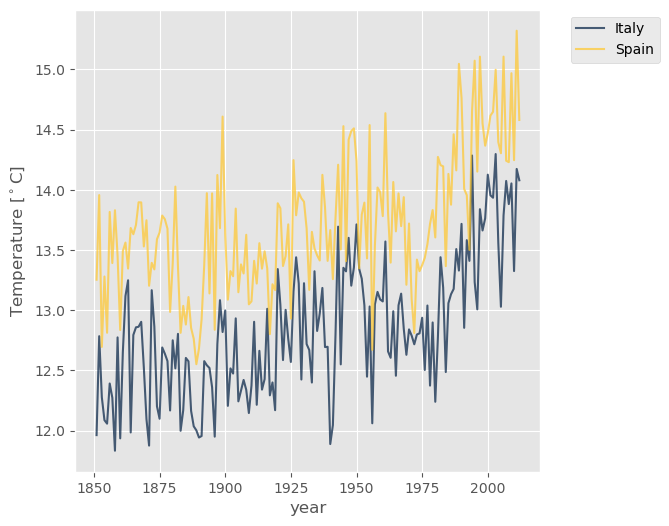

In [28]:
yourCountries.plot('year')
plt.ylabel('Temperature [$^\circ$C]')
plt.xticks(np.arange(1850, 2025, 25))
plt.show()

### <font color=blue> **Question 9. Discussion** </font>
In this markdown cell, explain an observation you see from the figure you generated.


Spain is overall higher average temperature but have very similar trends. Both do show overall increase, especially after 1975.

### <font color=blue> **Question 10.** </font>
Null and alternative hypothesis.  This time well will look at the overall trend rather diffences between starting and ending temperature.

Based on our preliminary figures and what we know about creating good hypotheses, set the null and alternative hypothesis below:  


-  Hypothesis: The temperatures are trending upward.
-  Null hypothesis:   The temperatures are not trending upward. 


To test the null hypothesis we're interested in identifying whether the temperature increased or decreased in each time period.  
Temperatures vary widely across countries and years, presumably due to the vast array of differences among the climates and human intervention. Rather than attempting to analyze the temperatures themselves, here we will restrict our analysis to whether or not temperatures increased or decreased over certain time spans. We will not concern ourselves with how much temperatures increased or decreased; only the direction of the changes - whether they increased or decreased.

The np.diff function takes an array of values and computes the differences between adjacent items of a list or array as such:

    [item 1 - item 0 , item 2 - item 1 , item 3 - item 2, ...]

Instead, we may wish to compute the difference between items that are two positions apart. For example, given a 5-element array, we may want:

    [item 2 - item 0 , item 3 - item 1 , item 4 - item 2]

The diff_n function below computes this result.

In [29]:
def diff_n(values, n):
    '''
    Parameters:
    values is an array of numbers
    n is the offset (how far apart the numbers are in the array)
    
    Example: 
    If values = [2, 6, 8, 9, 15] and n = 2,
    the function will subtract values that are 2 apart: (8 - 2), (9 - 6) and (15 - 9) 
    '''
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(2, 6, 8, 9, 15), 2)

array([6, 3, 7])

### <font color=blue> **Question 11.** </font> 
Implement the function changes that takes an array of temperatures for a country, ordered by increasing year. For all two-year periods (e.g., from 1960 to 1962), it computes and returns the number of increases minus the number of decreases.

For example, the array r = make_array(10, 7, 12, 9, 13, 9, 11) contains three increases (10 to 12, 7 to 9, and 12 to 13), 1 decrease (13 to 11), and one change that is neither an increase or decrease (9 to 9). Therefore, changes(r) would return 2, the difference between three increases and one decrease.

Hint: Consider using the `diff_n` function combined with boolean functions which use `np.count_non-zero` when array elements after using `diff_n` represent increases and separately when they represent decreases. Recall that Python counts `True` as 1 and `False` as 0, so counting non-zeros counts up all of the values that are `True`.

In [54]:
def changes(values, n = 2):

    ans = []
    
    for i in range(n,len(values)):
       ans.append(values[i] - values[i-n])
    
    count = 0    
    for n in ans:
        if n > 0:
            count = count + 1
        elif n < 0:
            count = count - 1

    return count

In [55]:
# renumber the test
check('tests/q11.py')

### <font color=blue> **Question 12.** </font>
Assign changes_by_country to a table with one row per country that has two columns: the Country name and the Temperature changes statistic computed across all years in our data set for that country. It may be useful to split this process into two steps.   The final table's first 2 rows should look like this:

|country    |avg changes| 
|-----------|-----------| 
|Afghanistan|18         | 
|Africa     |8          

Hint: You can use a `group` method to apply your `changes` function to each column in the original data set while grouping on each country. See this example from Olympic data below:

**Note** This temperature dataset has a few peculiarities, such as including Africa in the `country` column.

In [74]:
NORUSA = Table.read_table('NORUSA.csv')
NORUSA_NUMBERS = NORUSA.group(['Year','Team']) # Number of athletes per year
NORUSA_NUMBERS

Year,Team,count
1924,Norway,72
1924,United States,41
1928,Norway,68
1928,United States,31
1932,Norway,66
1932,United States,54
1936,Norway,94
1936,United States,58
1948,Norway,126
1948,United States,81


#### Now compute the increases - decreases for the winter olympics for each team

Below code allows us to group 'Team' across all the years of the Olympics to give the following table.
|Team| Year changes | count changes|
|----|---|---|
|Norway|20|10|
|United States|20|18

Apply this concept to create the table showing net change for each country.

In [57]:
NORUSA_NUMBERS.group('Team',changes)

Team,Year changes,count changes
Norway,20,10
United States,20,18


In [76]:
changes_by_country = Table().with_columns(
    "country", NORUSA.column('Team'),
    "avg changes", temp_change.column('T_diff'))
changes_by_country

ValueError: Column length mismatch. New column does not have the same number of rows as table.

In [66]:
# Need to renumber test
check('tests/q12.py')

### <font color=blue> **Question 13.** </font>
Assign test_stat to the total increases minus the total decreases for all two-year periods and all countries in our data set. For example, if the temperature in Albania went up 23 times and fell 17 times, the total change for Albania would be 6. We want the total value for all the countries together.

In [ ]:
test_stat = ...
print('Total increases minus total decreases, across all countries and years:', test_stat)

In [ ]:
# Need to renumber test
check('tests/q13.py')

"More increases than decreases," one person exclaims, "Temperatures tend to go up across two-year periods. What dire times we live in."

"Not so fast," another person replies, "Even if temperatures just moved up and down uniformly at random, there would be some difference between the increases and decreases. There were a lot of countries and a lot of years, so there were many chances for changes to happen. If country temperature increase and decrease at random with equal probability, perhaps this difference was simply due to chance!"

Based on the null hypothesis above that country temperatures increase and decrease by chance, we can simulate our test statistic.  Our test statistic should depend only on whether temperature increased or decreased, not on the size of any change. Thus we choose:

    Test Statistic: The number of increases minus the number of decreases

The cell below samples increases and decreases at random from a uniform distribution 100 times. The final column of the resulting table gives the number of increases and decreases that resulted from sampling in this way. Using sample_from_distribution is faster than using sample followed by group to compute the same result.

In [ ]:
uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
uniform.sample_from_distribution('Chance', 100)

### <font color=blue> **Question 14.** </font>
Complete the simulation below, which samples num_changes increases/decreases at random many times and forms an empirical distribution of your test statistic under the null hypothesis that increases and decreases are equally probable. Your job is to:

- fill in the function simulate_under_null, which simulates a single sample under the null hypothesis, and
- fill in its argument when it's called below.

As a hint, num_changes should be approximately the number of countries times the number of time comparisons (you can find the number of year comparisons by using diff_n().  

In [ ]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of your
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    uniform = Table().with_columns(
        "Change", make_array('Increase', 'Decrease'),
        "Chance", make_array(0.5,        0.5))
    sample = uniform.sample_from_distribution(..., ...)
    
    ... 
    
    return ...


In [ ]:
def empirical_distribution(tbl):
    num_changes = ...
    samples = make_array()
    for i in np.arange(10000):
        samples = np.append(samples, simulate_under_null(...)) 
    Table().with_column('Test statistic under null', samples).hist(bins=np.arange(0, max(samples) + max(samples) * 0.1, 2))
    return samples

In [ ]:
samples = empirical_distribution(...) 

In [ ]:
# Need to renumber test
check('tests/q14.py')

### <font color=blue> **Question 15.** </font>
Complete the analysis as follows:

1. Compute a P-value. (Hint: you can use np.count_nonzero())
2. Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses.
3. Describe your findings using simple, non-technical language. What does your analysis tell you about temperatures changes over time? What can you claim about causation from your statistical analysis?

**P-value:** ... 


### <font color=blue> **Question 16 Discussion:** </font>
What is your conclusion about the hypotheses?



**Findings:** ...

In [ ]:
pvalue = ...
pvalue

### <font color=blue> **Question 17.** </font>

#### Summary
You have tested for global warming two ways:

1. You compared temperatures in 1850 with 2014.  You found that the observed increase was too large to have been random.
2. You looked at all differences in temperature two years apart over a 35 year period, and found that there were far more increases than decreases, again, too many to be explained by random fluctuations.

In both cases, you rejected the null hypothesis as improbable.

<font color=blue>**Think back to the Olympic mini-project challenge question. Use what you have just learned to formulate a new strategy.<font>

**Challenge Question:** Does the host country team have an advantage? Use a markdown cell to create a strategy to address this question. 

### <font color=blue> **Question 18.** </font>
At the end of each lab, please include a reflection. 
* How did this lab go? 
* Have you used a t-test before in another class? Do you understand how to apply this test?
* Were there questions you found especially challenging you would like your instructor to review in class? 
* How long did the lab take you to complete?

Share your feedback so we can continue to improve this class!

**In the markdown cell below this one write your reflection on this lab.**

I did pretty well on the first 10, they were challenging but I was able to figure them out pretty well. I got complteely stumped at 11 and everything after that.
I have not used t-test before but I do understand how to apply it.
Please review everything from 11 on.
1-10 took me a little over an hour but the others stumped me for a while.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from gofer.ok import check
correct = 0
checks = [1, 4, 5, 7, 11, 12, 13, 14]
total = len(checks)
for x in checks:
    print('Testing question {}: '.format(str(x)))
    g = check('tests/q{}.py'.format(str(x)))
    if g.grade == 1.0:
        print("Passed")
        correct += 1
    else:
        print('Failed')
        display(g)

print('Grade:  {}'.format(str(correct/total)))

In [ ]:
print("Nice work ",name, user)
import time;
localtime = time.asctime( time.localtime(time.time()) )
print("Submitted @ ", localtime)